<a href="https://colab.research.google.com/github/anasalek/Pyhton_hw/blob/main/my_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Обучаю RNN на датасете shuttie/dadjokes
Потому что так веселее


##### Загрузка библиотек

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Загружаю датасет

In [ ]:
import pandas as pd

splits = {'train': 'train.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/shuttie/dadjokes/" + splits['train'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# смотрите какая прелесть
df.head()

,question,response
0,I asked my priest how he gets holy water,"He said it’s just regular water, he just boils..."
1,Life Hack: If you play My Chemical Romance lou...,your grass will cut itself
2,OMG. SISTERS. JAMES. CHARLES. IS. DOING. A,GIVEAWAY his career
3,Why did Mr. Potato Head get pulled over,He was baked
4,On zombie cravings. My kids and i had some fu...,Blood


In [ ]:
# наверное этого слишком много, у меня кончится cpu в колабе
df.count()

,0
question,52000
response,51760


In [ ]:
# надеюсь этого хватит, с большим кончается ОЗУ и моя память на локалке
data = df[:2000]

Некоторые строки были None, я их удалила. Там немного, штук 40

In [ ]:
data = data[data['response'].apply(lambda x: isinstance(x, str))]

In [ ]:
data

,question,response
0,I asked my priest how he gets holy water,"He said it’s just regular water, he just boils..."
1,Life Hack: If you play My Chemical Romance lou...,your grass will cut itself
2,OMG. SISTERS. JAMES. CHARLES. IS. DOING. A,GIVEAWAY his career
3,Why did Mr. Potato Head get pulled over,He was baked
4,On zombie cravings. My kids and i had some fu...,Blood
...,...,...
95,Conjunctivitis,com Now that's a site for sore eyes
96,What do your call a campground you just drove by,Past tents
97,How did the hot dog ask out his crush,He mustard up the courage
98,Why was Yoda afraid of seven,"Because six, seven eight"


In [ ]:
questions = data['question']
responses = data['response']

##### Готовим данные. Этот датасет можно использовать и для предсказания панчлайнов, и для полной генерации. Я попробую полную генерацию.

In [ ]:
# Инициализируем токенизатор
tokenizer = Tokenizer()

# Обучаем токенизатор на начале шуток
tokenizer.fit_on_texts(questions)

# Преобразуем данные в последовательности чисел
token_question = tokenizer.texts_to_sequences(questions)

In [ ]:
len(responses)

4975

In [ ]:
# Теперь обучаем токенизатор на панчлайнах
tokenizer.fit_on_texts(responses)

# Преобразовываем панчлайны в последовательности чисел
token_response = tokenizer.texts_to_sequences(responses)

In [ ]:
# Создаем входные и выходные данные
y = [] # здесь будут панчлайны (responses)
X = [] # а здесь начала (questions)

for q in token_question:
  X.append(q)
for r in token_response:
  y.append(r)

In [ ]:
y[9956]

[157, 95, 794]

In [ ]:
# Дополняем последовательности до одинаковой длины
X = pad_sequences(X, maxlen=32, dtype='int32')
y = pad_sequences(y, maxlen=32, dtype='int32')

# Преобразуем списки в массивы numpy
X = np.asarray(X)
y = np.array(y)

# Преобразуем y в one-hot encoding
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

Строим модель

In [ ]:
# Создаем модель
model = Sequential()

# Добавляем слой Embedding
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=X.shape[1]))

# Добавляем слой LSTM
model.add(LSTM(150, return_sequences=True)) # 150 units

# Добавляем полносвязный слой
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))

# Компилируем модель
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Выводим информацию о модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучаем модель
# C супер маленьким батчем
history = model.fit(X, y, epochs=50, batch_size=8, validation_split=0.2)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - accuracy: 0.7807 - loss: 4.1015 - val_accuracy: 0.8033 - val_loss: 1.8722
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.8078 - loss: 1.7060 - val_accuracy: 0.8032 - val_loss: 1.8397
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.8015 - loss: 1.7011 - val_accuracy: 0.8031 - val_loss: 1.8586
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.8034 - loss: 1.6357 - val_accuracy: 0.8029 - val_loss: 1.8825
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 124ms/step - accuracy: 0.8026 - loss: 1.5864 - val_accuracy: 0.8031 - val_loss: 1.9025
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.8082 - loss: 1.5467 - val_accuracy: 0.8033 - val_loss: 1.9280
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.8064 - loss: 1.5197 - val_accuracy: 0.8033 - val_loss: 1.9569
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.8070 - loss: 1

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 100)        │       694,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 150)        │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32, 6940)       │     1,047,940 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,677,622 (21.66 MB)

 Trainable params: 1,892,540 (7.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,785,082 (14.44 MB)

Я так понимаю, что это ужасные результаты? Отлично, работаем

63/63 - 9s - 150ms/step - accuracy: 0.8260 - loss: 1.2169
Test accuracy: 0.8260


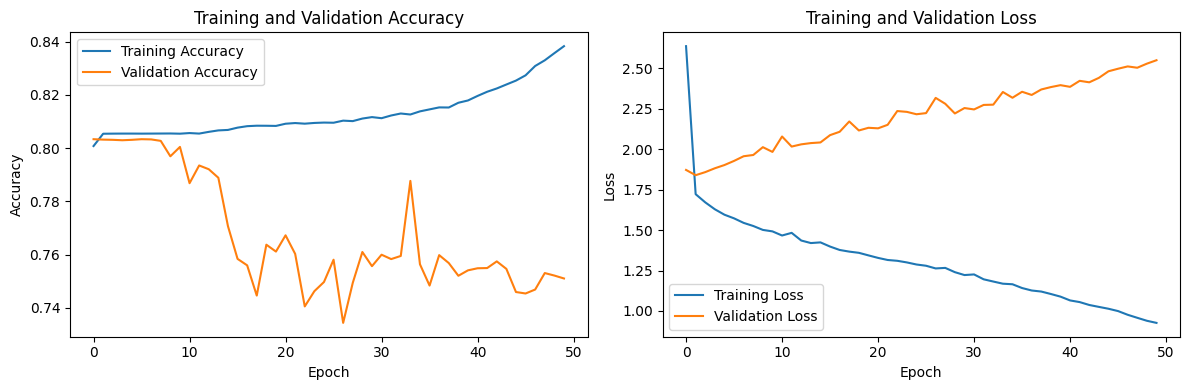

In [ ]:
# Оцениваем модель
test_loss, test_acc = model.evaluate(X, y, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Это результаты модели с теми же параметрами, но обученной на 1000 строках. Как видно, работает очень плохо, выучила training и... 2000 тоже мало. Но больше я не могу в колабе, на локалке тоже не получилось...

32/32 - 4s - 137ms/step - accuracy: 0.8037 - loss: 1.3636
Test accuracy: 0.8037


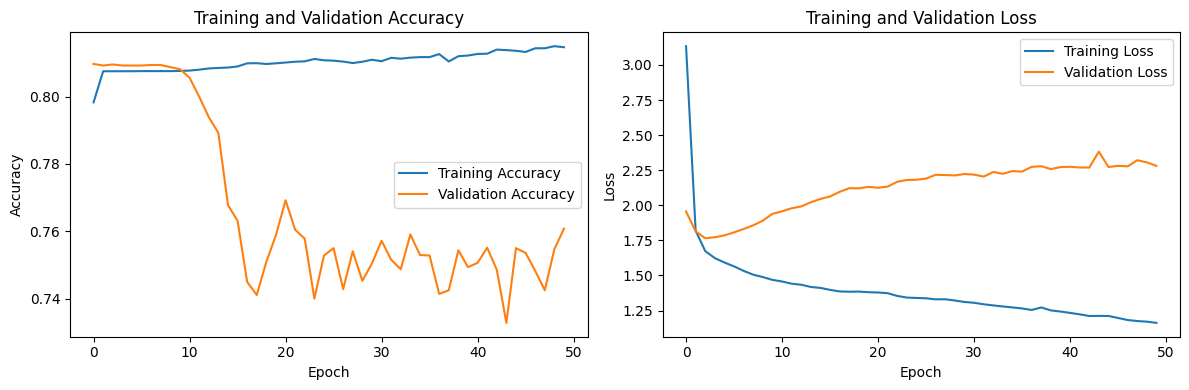

In [ ]:
# Оцениваем модель
test_loss, test_acc = model.evaluate(X, y, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка аккуратности (точности) модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Смотрим как это (не) работает

In [ ]:
def generate_joke(seed_text: str, max_sequence_len, next_words: int):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(f'убедимся, что seed_text токенизируется: {token_list}')
    pad_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    print(pad_sequences)
    predicted = np.argmax(model.predict(pad_list, verbose=0)[0])
    print(f'predicted: {predicted}') # вот, предсказал же какой-то индекс

    output = ''

    for word, index in tokenizer.word_index.items():
      if index == predicted: # но к этому индексу не нашлось слова, поэтому output пустой?
        output = word
        break
    print(word)
    print(index)
    print(f'response: {output}')
    seed_text += " " + output
    return output
#seed_text = "What does a fox say?"
generated_text = generate_joke("Why do not blind guys skydive?", X.shape[1], 5)
print(generated_text)

убедимся, что seed_text токенизируется: [23, 17, 62, 621, 339]
<function pad_sequences at 0x78b98c75dc60>
predicted: 6940
akhbar
6939
response: 



## Вывод
Короче, я не понимаю, это просто модель ужасно работает (она по метрикам ужасная, да) или проблема в последней ячейке кода... иначе почему она предсказывает один индекс и output пустой. Я сдаю так, и так долго разбиралась с этим и пропустила все дедлайны((

In [ ]:
# Сохраняем модель
model.save('dad_jokes_generator_2000.keras')